In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import csr_matrix
from scipy.sparse import hstack


In [35]:
path = "/Users/aryagupta/Desktop/yt-sentiment-analysis/youtube-comments-sentiment-analysis/data/processed/preprocessed_v1.csv"

data = pd.read_csv(path)

In [36]:
data.head()

,clean_comment,category
0,family mormon have never tried explain them th...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [22]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

with mlflow.start_run():
    mlflow.log_param("parameters_1", 10)
    mlflow.log_metric("metrics_1", 0.95)

🏃 View run debonair-stag-54 at: http://127.0.0.1:5000/#/experiments/0/runs/3f06b4ab04e24b1e8ccf2dec833eac7c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


In [37]:
data.shape

(36793, 2)

In [38]:
data = data.dropna()

In [39]:
data = data.drop_duplicates()

In [40]:
data['clean_comment'] = data['clean_comment'].str.strip()

In [41]:
vectorizer = CountVectorizer(max_features=10000)

In [42]:
vectorizer

CountVectorizer(max_features=10000)

In [43]:
# converting to array
X = vectorizer.fit_transform(data['clean_comment']).toarray()
y = data['category']

In [45]:
X.shape, y.shape

((36607, 10000), (36607,))

In [48]:
X, y

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(36607, 10000)),
 0        1
 1        1
 2       -1
 3        0
 4        1
         ..
 36788    0
 36789    1
 36790    0
 36791    1
 36792    0
 Name: category, Length: 36607, dtype: int64)

In [49]:
mlflow.set_experiment("Random Forest Baseline Model")

2025/05/05 18:31:28 INFO mlflow.tracking.fluent: Experiment with name 'Random Forest Baseline Model' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/766508419071346459', creation_time=1746450088374, experiment_id='766508419071346459', last_update_time=1746450088374, lifecycle_stage='active', name='Random Forest Baseline Model', tags={}>

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)

2025/05/05 19:51:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_Baseline_Modek_TrainTestSplit at: http://127.0.0.1:5000/#/experiments/766508419071346459/runs/f331c367aea34ab9b1b51e451ec899bd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/766508419071346459
Accuracy: 0.637530729308932


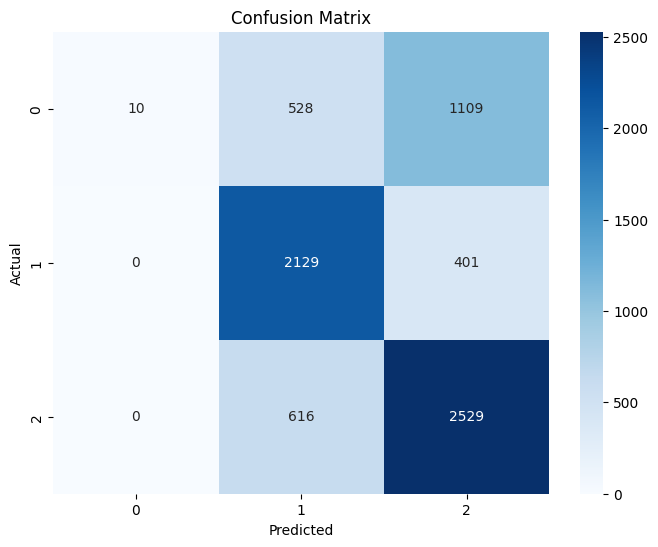

In [55]:
with mlflow.start_run() as run:
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_Modek_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")
    mlflow.set_tag("description", "This is a simple Random Forest Model that Will be treated as Baseline Model ")
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    n_estimators = 300
    max_depth = 18

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    plt.savefig("/Users/aryagupta/Desktop/yt-sentiment-analysis/youtube-comments-sentiment-analysis/plots/confusion_matrix.png")
    mlflow.log_artifact("/Users/aryagupta/Desktop/yt-sentiment-analysis/youtube-comments-sentiment-analysis/plots/confusion_matrix.png")

    mlflow.sklearn.log_model(model, "random_forest_model")

    data.to_csv("/Users/aryagupta/Desktop/yt-sentiment-analysis/youtube-comments-sentiment-analysis/data/interim/mlflow_v1.csv", index=False)
    mlflow.log_artifact("/Users/aryagupta/Desktop/yt-sentiment-analysis/youtube-comments-sentiment-analysis/data/processed/preprocessed_v1.csv")

print(f"Accuracy: {accuracy}")

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.01      0.01      1647
           0       0.65      0.84      0.73      2530
           1       0.63      0.80      0.70      3145

    accuracy                           0.64      7322
   macro avg       0.76      0.55      0.48      7322
weighted avg       0.72      0.64      0.56      7322



### Some Key Observations:
1. The accuracy of the model is around 63% which is not satisfactory.
2. The recall of the -1 class is Very very low which needs to be fixed
3. Precision of -1 class is 100% which needs further investigration.
4. We need to create a model that can classify -1 data points as well.
5. We need to fix the imbalance dataset problem which might increase the accuracy and Recall.

### Baseline Model 2

In [59]:
path = "/Users/aryagupta/Desktop/yt-sentiment-analysis/youtube-comments-sentiment-analysis/data/processed/preprocessed_v2.csv"

data_v2 = pd.read_csv(path)

In [60]:
data_v2 = data_v2.dropna()

In [61]:
data_v2 = data_v2.drop_duplicates()

In [62]:
data_v2['clean_comment'] = data_v2['clean_comment'].str.strip()

In [63]:
vectorizer = CountVectorizer(max_features=10000)

In [64]:
vectorizer

CountVectorizer(max_features=10000)

In [68]:
data_v2.head()

,clean_comment,category,word_count,num_stopwords,num_char
0,family mormon never tried explain still stare ...,1,39,13,259
1,buddhism much lot compatible christianity espe...,1,196,59,1268
2,seriously say thing first get complex explain ...,-1,86,40,459
3,learned want teach different focus goal not wr...,0,29,15,167
4,benefit may want read living buddha living chr...,1,112,45,690


In [71]:
X = vectorizer.fit_transform(data_v2[['clean_comment', 'word_count', 'num_stopwords', 'num_char']]).toarray()
y = data_v2['category']

In [72]:
X.shape, y.shape

((4, 4), (36461,))

In [74]:
mlflow.set_experiment("Random Forest Baseline Model V2")

2025/05/05 20:13:16 INFO mlflow.tracking.fluent: Experiment with name 'Random Forest Baseline Model V2' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/468279134609977584', creation_time=1746456196378, experiment_id='468279134609977584', last_update_time=1746456196378, lifecycle_stage='active', name='Random Forest Baseline Model V2', tags={}>

In [80]:
X_text = vectorizer.fit_transform(data_v2['clean_comment'])

X_num = data_v2[['word_count', 'num_stopwords', 'num_char']].values

X_num_sparse = csr_matrix(X_num)

X = hstack([X_text, X_num_sparse])

y = data_v2['category']

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

🏃 View run RandomForest_Baseline_Model_TrainTestSplit_v2 at: http://127.0.0.1:5000/#/experiments/468279134609977584/runs/57d89acb78e24fc3b9cfe7db564358f9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/468279134609977584
Model logged with run ID: 57d89acb78e24fc3b9cfe7db564358f9
Test accuracy: 0.6211


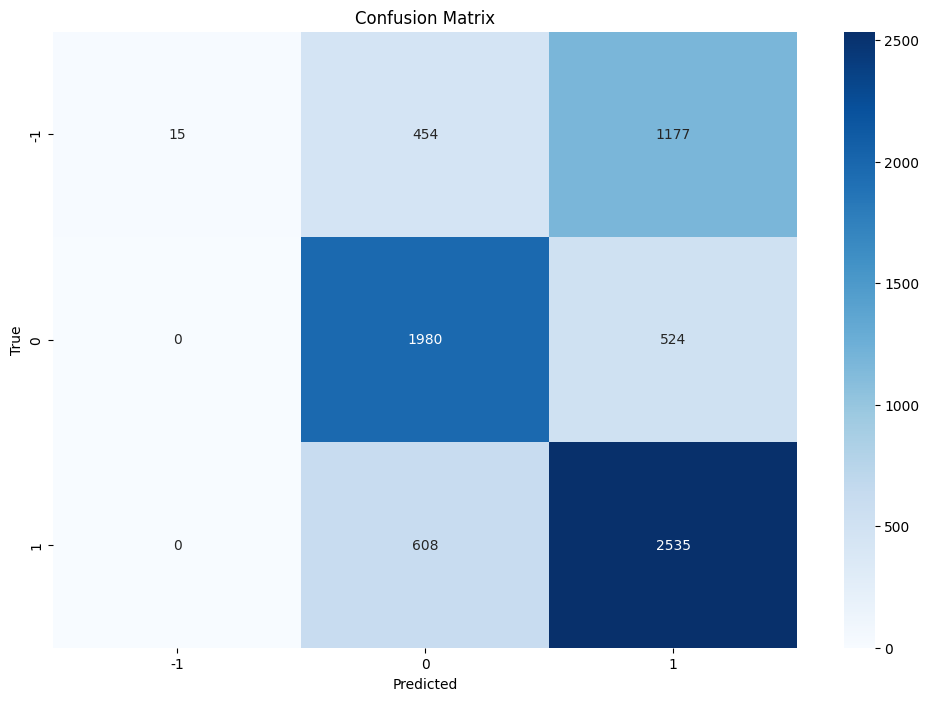

In [83]:
with mlflow.start_run() as run:
    # Basic Run Metadata 
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_Model_TrainTestSplit_v2")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")
    mlflow.set_tag("description", "Baseline Random Forest Model with Combined Text+ Numerical Features")
    
    # Feature Engineering Logging
    mlflow.log_param("text_feature", "clean_comment")
    mlflow.log_param("numerical_features", ["word_count", "num_stopwords", "num_char"])
    mlflow.log_param("vectorizer_type", type(vectorizer).__name__)
    mlflow.log_params({
        "vectorizer_max_features": vectorizer.max_features,
        "vectorizer_ngram_range": vectorizer.ngram_range,
        "vectorizer_stop_words": bool(vectorizer.stop_words)
    })
    
    # ===== Model Parameters =====
    model_params = {
        "n_estimators": 300,
        "max_depth": 18,
        "random_state": 42
    }
    mlflow.log_params(model_params)
    
    # Model Training 
    model = RandomForestClassifier(**model_params)
    model.fit(X_train, y_train)
    
    # Predictions & Metrics 
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    mlflow.log_metrics({
        "accuracy": accuracy,
        "train_samples": X_train.shape[0],
        "test_samples": X_test.shape[0]
    })
    
    # Detailed Classification Report 
    clf_report = classification_report(y_test, y_pred, output_dict=True)
    for class_name, metrics in clf_report.items():
        if isinstance(metrics, dict):
            for metric, value in metrics.items():
                mlflow.log_metric(f"{class_name}_{metric}", value)
    
    # Confusion Matrix Visualization 
    plt.figure(figsize=(12, 8))
    sns.heatmap(confusion_matrix(y_test, y_pred), 
                annot=True, fmt="d", 
                cmap="Blues",
                xticklabels=model.classes_,
                yticklabels=model.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    confusion_matrix_path = "/Users/aryagupta/Desktop/yt-sentiment-analysis/youtube-comments-sentiment-analysis/plots/confusion_matrix_v2.png"
    plt.savefig(confusion_matrix_path)
    mlflow.log_artifact(confusion_matrix_path)
    
print(f"Model logged with run ID: {run.info.run_id}")
print(f"Test accuracy: {accuracy:.4f}")